<hr style="border:2px solid gray">

# <center>Lung Disease Detection (Hernia Classification)</center>

<hr style="border:2px solid gray">

This exercise shows a lung disease detection example that classify Hernia disease from X-ray images by using transfer learning from a pre-trained Convolutional Neural Network (CNN). The model will be trained with a small number of chest X-ray image dataset to demonstrate basic AI workflow:
1. Load data
2. Analze data
2. Prepare data
3. Build model
4. Train model
5. Evaluate model

By the end of this exercise, you will be able to:
- Load dataset from file and save dataset to file.
- Preprocess and augment data using ImageDataGenerator.
- Adapt a pretrained model to our dataset and train a classifier using InceptionResNetV2.
- Evaluate a model with metrics and understand the performance of a model.
- Issue that we might encounter and improvement to be made.

## Import Libraries
Import required packages into your program to get started:

In [1]:
import os
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.metrics import  confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, classification_report, accuracy_score, ConfusionMatrixDisplay, cohen_kappa_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16, VGG19, ResNet101V2, ResNet50V2, InceptionV3, InceptionResNetV2, NASNetLarge, DenseNet121, DenseNet169, DenseNet201, Xception
from tensorflow.keras.optimizers import Nadam, SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy, categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

import sys
import argparse
import joblib
import json

## Load Data

**Download dataset from source repo.**

In [2]:
import os
from pathlib import Path
import urllib.request
import tarfile

data_dir = '../data/raw'
dataset_url="https://github.com/ZoieD/Hernia_X-ray_images_sample/raw/main/Hernia_sample20.tgz"
Path(data_dir).mkdir(parents=True, exist_ok=True)

thetarfile = dataset_url
ftpstream = urllib.request.urlopen(thetarfile)
thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
thetarfile.extractall(data_dir)
print(f'data saved to {data_dir}')

data saved to ../data/raw


The dataset will be a set of chest X-ray images that have been divided into two different folders named negative (for non-Hernia images) and positive (Hernia images). There is a dataset.csv file that stores the image paths with their corresponding labels. 

In this exercise, we will be using Hernia_sample20 that contains 20 negative sample images and 20 positive sample images.

**Load data from dataset.csv file at Hernia_sample20 as a data frame called `df`.**

In [3]:
raw_csv_path = "../data/raw/Hernia_sample20/dataset.csv"

df = pd.read_csv(raw_csv_path)

In [4]:
df

,image_index,labels
0,./datasets-registry/Hernia_sample20/positive/0...,Hernia
1,./datasets-registry/Hernia_sample20/positive/0...,Hernia
2,./datasets-registry/Hernia_sample20/positive/0...,Hernia
3,./datasets-registry/Hernia_sample20/positive/0...,Hernia
4,./datasets-registry/Hernia_sample20/positive/0...,Hernia
5,./datasets-registry/Hernia_sample20/positive/0...,Hernia
6,./datasets-registry/Hernia_sample20/positive/0...,Hernia
7,./datasets-registry/Hernia_sample20/positive/0...,Hernia
8,./datasets-registry/Hernia_sample20/positive/0...,Hernia
9,./datasets-registry/Hernia_sample20/positive/0...,Hernia


Note that the image paths at image_index column are not the same as our actual image paths.

**Correct the image paths at image_index column with actual image paths.**

In [5]:
df["image_index"]= df["image_index"].apply(lambda x: x.replace('./datasets-registry', '../data/raw'))

In [6]:
df

,image_index,labels
0,../data/raw/Hernia_sample20/positive/00021330_...,Hernia
1,../data/raw/Hernia_sample20/positive/00009759_...,Hernia
2,../data/raw/Hernia_sample20/positive/00009507_...,Hernia
3,../data/raw/Hernia_sample20/positive/00002802_...,Hernia
4,../data/raw/Hernia_sample20/positive/00030310_...,Hernia
5,../data/raw/Hernia_sample20/positive/00029817_...,Hernia
6,../data/raw/Hernia_sample20/positive/00021943_...,Hernia
7,../data/raw/Hernia_sample20/positive/00019733_...,Hernia
8,../data/raw/Hernia_sample20/positive/00000003_...,Hernia
9,../data/raw/Hernia_sample20/positive/00020915_...,Hernia


**Create new directory data/processed/Hernia and save the processed data frame `df` to the directory called dataset.csv.**

In [7]:
processed_data_dir ="../data/processed/Hernia" 

os.makedirs(processed_data_dir, exist_ok=True)

processed_data_path = os.path.join(processed_data_dir, "dataset.csv")

df.to_csv(processed_data_path, index=False)

## Analyze Data
To understand and visualize on the data. 

**Determine the unique labels from the data frame.**

In [8]:
labels = df['labels'].unique()

In [9]:
print(labels)

['Hernia' '0']


**Determine the total number of sample images for each label from the data frame.**

In [10]:
df['labels'].value_counts()

Hernia    20
0         20
Name: labels, dtype: int64

**Let's plot the first 5 images for each label at the data frame.**

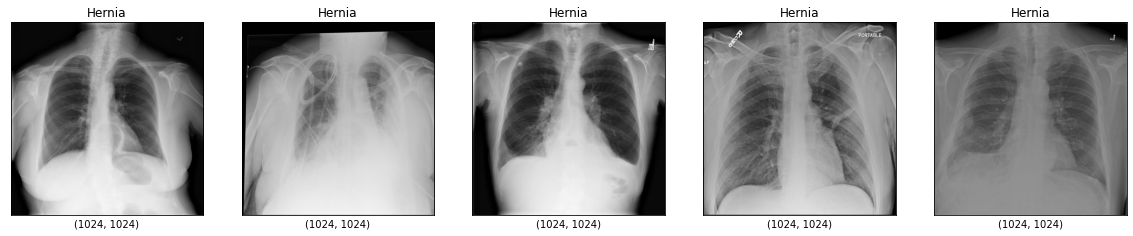

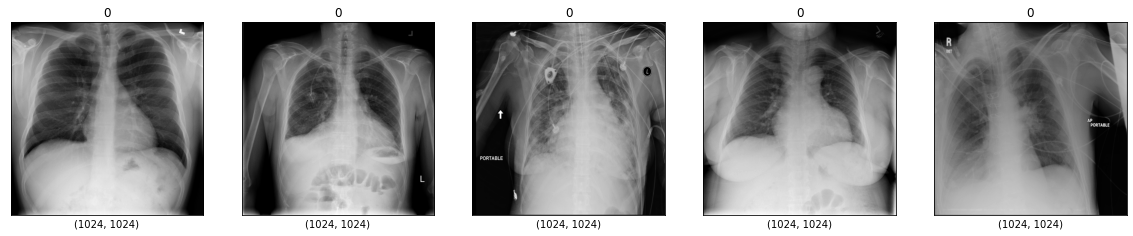

In [11]:
number_plot = 5

for i in range(len(labels)):
    plt.figure(figsize=(20,20))
    for j in range(number_plot):
        img_path = df.image_index[df['labels'] == labels[i]].iloc[j]
        img = mpimg.imread(img_path)
        plt.subplot(1,number_plot,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap='gray')
        plt.title(labels[i])
        plt.xlabel(img.shape)
    plt.show()

Note that the size of images are not similar.

Can you determine where is the Hernia from the X-ray images with label Hernia?

## Prepare Data

### Split Data
The data is to be splitted for model training and testing. We have to note that a learning model fits a training set well, that does not mean it is a good model. It could be overfitting the train set and as a result predictions on the test set would be poor. The error of your model as measured on train set will be lower than the error on any other data set.

Therefore, we usually break down our dataset into the three sets:
- Train set - use to train the model. (60%)
- Cross validation set - use to tune the hyperparameters and evaluate the model. (20%)
- Test set - use to test the model after the model has gone through initial vetting by the validation set. (20%)

**Split dataset from `df` into `train_df`, `val_df` and `test_df` with `train_test_split`.**

In [12]:
train_val_df, test_df = train_test_split(
    df,
    test_size = 0.2,
    random_state = 123,
    stratify=df['labels']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size = 0.2,
    random_state = 123,
    stratify=train_val_df['labels']
)

In [13]:
print(f"Number of train set = {len(train_df)}")
print(f"Number of validation set = {len(val_df)}")
print(f"Number of test set = {len(test_df)}")

Number of train set = 25
Number of validation set = 7
Number of test set = 8


### Image Augmentation
Image augmentation technique is a great way to expand the size of our data set which apply different transformations to original images which results in multiple transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending on the augmentation techniques you apply like shifting, rotating, flipping, etc. It incorporates a level of variation in the data set which allow our model to generalize better on unseen data. It is best used when you are working with a relatively small amount of images and your model is overfitting.</br>

Keras ImageDataGenerator is used to augment and normalize our image dataset on the fly with model training. ImageDataGenerator will ensure that the model receives new variations of the images at each epoch of training.

**Initialize two objects from `ImageDataGenerator` which one having various transformations and normalization for train set called `train_datagen` and the other one with only normalization for validation and test set called `val_test_datagen`.**

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    shear_range=0.3,
                                    zoom_range=0.3,
                                    horizontal_flip=True, 
                                    vertical_flip=False,
                                    fill_mode="nearest")

val_test_datagen = ImageDataGenerator(rescale=1./255.)

**Use the two initialzed objects to create generators from data frame. Create generator called `train_generator` from `train_datagen`, `val_generator` and `test_generator` from `val_test_datagen` with `train_df`, `val_df` and `test_df` respectively by using function `flow_from_dataframe`.**

In [15]:
labels = train_df['labels'].unique()
labels = list(labels)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image_index',
                                                    y_col='labels',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    seed = 42,
                                                    shuffle=True,
                                                    classes = labels,
                                                    interpolation='nearest')

val_generator = val_test_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='image_index',
                                                        y_col='labels',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        seed = 42,
                                                        classes = labels,
                                                        shuffle=True)
                                                    

test_generator = val_test_datagen.flow_from_dataframe(dataframe=test_df,
                                                        x_col='image_index',
                                                        y_col='labels',
                                                        target_size=(224, 224),
                                                        batch_size=1,
                                                        class_mode='binary',
                                                        classes = labels,
                                                        shuffle=False)

Found 25 validated image filenames belonging to 2 classes.
Found 7 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.


**Print the class indices from `train_generator` to see how the label changed.**

In [16]:
indices = train_generator.class_indices

In [17]:
print("indices:", indices)

indices: {'Hernia': 0, '0': 1}


Note that the label for Hernia is changed to 1.

**Take a look at how images from the training set generated by `train_generator` has been augmented with simple transformations:**

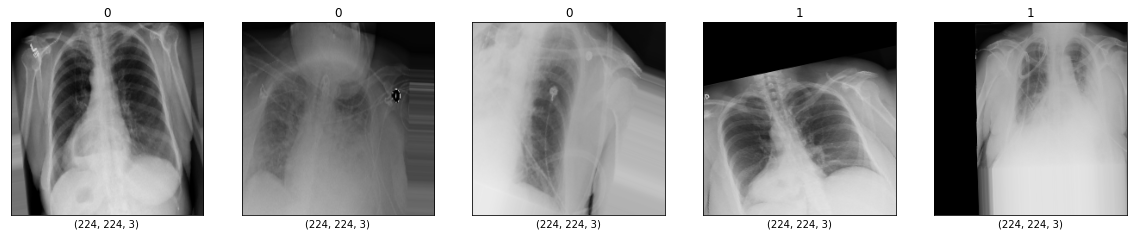

In [18]:
image = train_generator.next()[0]

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i])
    plt.title(train_generator.classes[i])
    plt.xlabel(image[i].shape)

## Build Model - Using InceptionResNetV2 for Transfer Learning
A pre-trained model is a network that is already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. This is also known as transfer learning.

Inception-ResNet-v2 is selected as a pretrained model for training our classifer. Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 164 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299, and the output is a list of estimated class probabilities.

This model formulated based on a combination of the Inception structure and the Residual connection. In the Inception-Resnet block, multiple sized convolutional filters are combined with residual connections. The usage of residual connections not only avoids the degradation problem caused by deep structures but also reduces the training time.

<img src='../images/inceptionresnet.png' width="600"></br>

Source code: https://github.com/keras-team/keras/blob/v2.10.0/keras/applications/inception_resnet_v2.py#L43-L273

### InceptionResNetV2

**Initialize `InceptionResNetV2` with pretrained weights from ImageNet by specifying `weights='imagenet'` as `inceptresnet`.**

In [19]:
inceptresnet = InceptionResNetV2(
    weights='imagenet')

**Print the model summary for `inceptresnet` to see all the model's layers, the shapes of their outputs, and the total number of parameters, trainable and non-trainable.**

In [20]:
inceptresnet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model.

**Print the last 2 layers of the network.**

In [21]:
nb_layers = len(inceptresnet.layers)

print(inceptresnet.layers[nb_layers - 2].name)
print(inceptresnet.layers[nb_layers - 1].name)

avg_pool
predictions


### Transfer Learning
We cannot use the model directly to train on the data. This is because the input layer and output layers of InceptionResNetV2 are not compatible in our case.

Fortunately, we can define input image shape, delete the top layer and create a new classifier layer. We can achieve this in three steps:
1. **Define input image shape**
    * Set `input_shape` in `inceptresnet` as image shape defined at `train_generator` with 3 channel to compatible with input of the network.
2. **Delete the top layer (the classification layer)**
    * Set `include_top` in `inceptresnet` as False
3. **Add a new output classifier layer from `inceptresnet.output`**
     - [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D): name='gap'
     - [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): units=256, activation='sigmoid', kernel_initializer='he_uniform'
     - [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): for default value.
     - [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout): rate=0.5
     - [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): units=1, activation='sigmoid', name='fc_out', kernel_initializer='he_uniform'

Note that the last layer is a fully connected layer with 1 neuron and a sigmoid activation to solve the binary classification problem.

In [22]:
inceptresnet = InceptionResNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

x = inceptresnet.output
x = GlobalAveragePooling2D(name="gap")(x)
x = Dense(256, activation='elu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation = "sigmoid", name="fc_out", kernel_initializer='he_uniform')(x)

model = Model(inputs=inceptresnet.input, outputs=pred)

**Print the model summary and compare with the original inceptresnet model.**

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                             

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:
- Optimizer - This is how the model is updated based on the data it sees and its loss function.
- Loss function - This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- Metrics - Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

**Define an optimizer called `optimizer` using `Adam` with learning rate 0.001**

**Then compile the model with Adam optimizer, `loss` as `binary_crossentropy` for binary classification problem and `metrics` as `['accuracy']`**

In [24]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## Train Model
Train model with train set and validation set and several callbacks are defined to monitor on a metric where validation lost is used in our case. The callbacks are: </br>
- [ModelCheckPoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - To save the model weights when validation lost has stopped improving.
- [ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - To reduce the learning rate when validation lost has stopped improving.
- [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - Stop training when validation lost has stopped improving.

In [25]:
model_dir = "../models/Hernia" 

os.makedirs(model_dir, exist_ok=True)

model_saved_path = os.path.join(model_dir, "model.h5")

checkpoint = ModelCheckpoint(model_saved_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')                         
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
callbacks_list = [checkpoint, reduce_lr, earlyStopping]

history = model.fit(train_generator, 
        steps_per_epoch=math.ceil(train_generator.n/train_generator.batch_size),
        epochs=5,
        validation_data=val_generator,
        validation_steps=math.ceil(val_generator.n/val_generator.batch_size),
        callbacks=callbacks_list)

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.6800
Epoch 1: val_loss improved from inf to 0.42171, saving model to ../models/Hernia\model.h5
1/1 [==============================] - 69s 69s/step - loss: 0.8376 - accuracy: 0.6800 - val_loss: 0.4217 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.8000
Epoch 2: val_loss did not improve from 0.42171
1/1 [==============================] - 39s 39s/step - loss: 0.7064 - accuracy: 0.8000 - val_loss: 0.6094 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.8000
Epoch 3: val_loss did not improve from 0.42171
1/1 [==============================] - 17s 17s/step - loss: 0.5646 - accuracy: 0.8000 - val_loss: 3.1539 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 1.7805 - accuracy: 0.7200
Epoch 4: val_loss did not imp

Plot the training and validation accuracy:

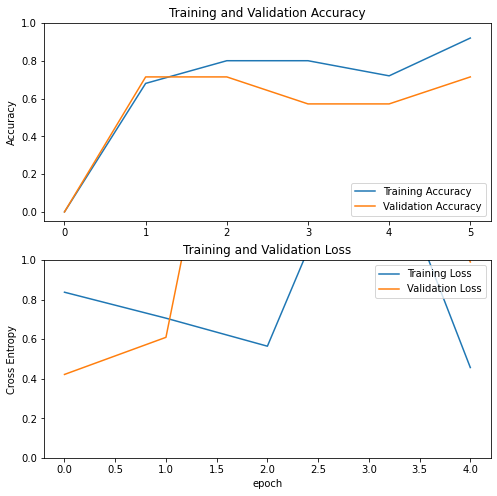

In [26]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluate Model
Evaluate model on test set with different metrics to determine the performance of the model.

**Predict test set generate from `test_generator` using `model.predict` and store the predicted results at a variable called `y_pred`.**

**Obtain the true labels of the test set from `test_generator.classes`.**

In [27]:
y_pred = model.predict(test_generator, steps=(math.ceil(test_generator.n/test_generator.batch_size)), verbose=1)
y_true = test_generator.classes

8/8 [==============================] - 6s 226ms/step


Use the predicted results to calculate different metrics.

**Confusion Matrix**

It is also known as an error matrix which is a specific table layout that allows visualization of how many samples from each label got predicted correctly, typically for supervised learning. 
The beauty of the confusion matrix is that it actually allows us to see where the model fails and where the model succeeds, especially when the labels are imbalanced. In other words, we are able to see beyond the model's accuracy.

<img src='../images/confusion_matrix.png' width="500"></br>

Note that some people use predicted values on the rows, and actual values on the columns, which is just the transpose of this matrix. Some people start by the negative class first then the positive class. These are just different ways of drawing the confusion matrix, and all convey the same thing.

There are four potential outcomes here:

* True Negative (TN) - A test result that correctly indicates the absence of a condition or characteristic. (You predicted negative and it’s true)
* False Positive (FP) - A test result which wrongly indicates that a particular condition or attribute is present. (You predicted positive and it’s false)
* False Negative (FN) - A test result which wrongly indicates that a particular condition or attribute is absent. (You predicted negative and it’s false)
* True Positive (TP) - A test result that correctly indicates the presence of a condition or characteristic. (You predicted positive and it’s true)

**Create confusion matrix call `cm` with `confusion_matrix()` function from true and predicted results.**

In [28]:
cm = confusion_matrix(y_true, y_pred >= 0.5)

In [29]:
print(cm)

[[1 3]
 [0 4]]


**Display the created confusion matrix with `ConfusionMatrixDisplay()` function.**

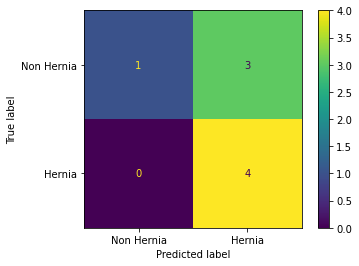

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Hernia', 'Hernia'])
disp.plot()
plt.show()

**Obtain the TN, FP, FN and TP from the confusion matrix using `ravel()` function.**

In [31]:
TN, FP, FN, TP = cm.ravel()

In [32]:
print (f"True Negative (TN): {TN}")
print (f"False Positive (FP): {FP}")      
print (f"False Negative (FN): {FN}")
print (f"True Positiv (TP): {TP}")

True Negative (TN): 1
False Positive (FP): 3
False Negative (FN): 0
True Positiv (TP): 4


Perform calculation to obtain metrics as below:

**Accuracy**

accuracy = (TP+TN) / (TP+FP+FN+ TN)

In [33]:
acc = (TP+TN)/(TP+FP+FN+TN)

In [34]:
print(acc)

0.625


**Sensitivity (Recall, Hit Rate, True Positive Rate)** 

Out of all actual positive samples, how many did us correctly detect? 

sensitivity = TP / (TP + FN)

In [35]:
sensitivity = TP/(TP+FN)

In [36]:
print(sensitivity)

1.0


**Specificity (Selectivity, True Negative Rate)**

Out of all actual negative samples, how many us we correctly detect? 

specificity = TN / (TN+FP)

In [37]:
specificity = TN/(TN+FP)

In [38]:
print(specificity)

0.25


**False Negative Rate**

Out of all actual positive samples, how many did us wrongly detect? 

FNR = FN / (FN+TP) = 1 - sensitivity

In [39]:
FNR = FN/(FN+TP)

In [40]:
print(FNR)

0.0


**False Positive Rate** 

Out of all actual negative samples, how many did us wrongly detect? 

FPR = FP / (FP+TN) = 1 - specificity

In [41]:
FPR = FP/(FP+TN)

In [42]:
print(FPR)

0.75


**Precision (Positive Predictive Value)**

Precision calculates  of how many times a positive prediction is correct out of total predictions made.

precision = TP / (TP+FP)

In [43]:
precision = TP/(TP+FP)

In [44]:
print(precision)

0.5714285714285714


**Negative Predictive Value**

NPV calculates  of how many times a negative prediction is correct out of total predictions made.

NPV = TN / (TN+FN)

In [45]:
NPV = TN/(TN+FN)

In [46]:
print(NPV)

1.0


**F1 score**

F1 score is the hormonic mean of sensitivity and precision.

f1 = 2 x (sensitivity x precision) / (sensitivity + precision)

In [47]:
f1 = 2 * (sensitivity * precision) / (sensitivity + precision)

In [48]:
print(f1)

0.7272727272727273


**AUC - ROC Curve**

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

<img src='../images/auc.png'></br>

**Use `roc_auc_score` function with true and predicted results to obtain AUC.**

In [49]:
auc = roc_auc_score(y_true, y_pred)

In [50]:
print ('AUC: ', round(auc, 3))

AUC:  0.812


## Save Result

**Create new directory /reports/Hernia and save ave the results (AUC, f1 score, confusion matrix and accuracy) into file as JSON format called scores.json for future reference.**

In [51]:
cm = cm.tolist()

report_dir = "../reports/Hernia" 
os.makedirs(report_dir, exist_ok=True)

score_file = os.path.join(report_dir, "scores.json")
with open(score_file, "w") as f:
    scores = {
        "auc": auc,
        "f1": f1,
        "cm": cm,
        "acc": acc
        }

    json.dump(scores, f, indent=4)